Saving Cat.jpg to Cat.jpg


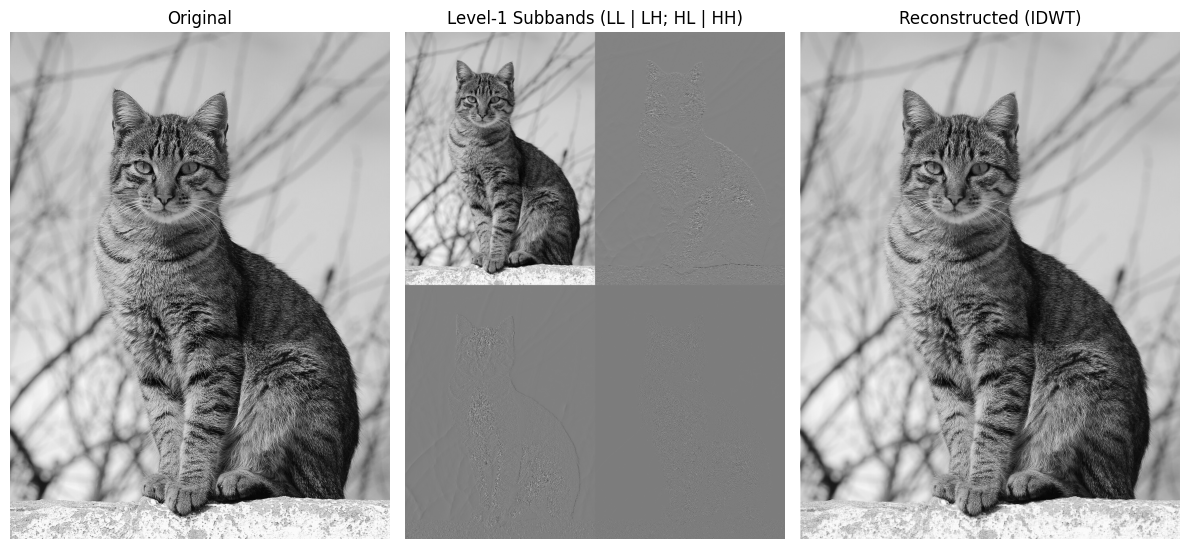

Image shape: (1282, 960), DWT levels: 1
Reconstruction MSE: 9.359394e+02, max|error|: 4.830000e+02


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ============== 1) Load or create an image ==============
img = None
try:
    from google.colab import files
    from PIL import Image
    import io
    uploaded = files.upload()  # choose a JPG/PNG
    fname = next(iter(uploaded))
    img = Image.open(io.BytesIO(uploaded[fname])).convert('L')  # grayscale for clarity
except Exception:
    # Fallback: synthetic test image (gradient + shapes)
    print("No upload detected; using a synthetic grayscale image.")
    h, w = 256, 320
    yy, xx = np.mgrid[0:h, 0:w]
    img = 0.4*xx + 0.6*yy
    img = (img - img.min())/(img.max()-img.min())
    # draw a rectangle + circle
    rr = (xx-80)**2 + (yy-160)**2
    img = img + (rr < 45**2)*0.5
    img = np.clip(img, 0, 1)
    from PIL import Image
    img = Image.fromarray((img*255).astype(np.uint8))

img = np.asarray(img, dtype=np.float32)  # shape (H, W), range 0..255 (uint8 casted to float)

# ============== 2) Haar filters and helpers ==============
# Haar low/high analysis filters (orthonormal)
sqrt2 = np.sqrt(2.0)
h0 = np.array([1.0, 1.0], dtype=np.float32) / sqrt2  # low-pass
h1 = np.array([1.0,-1.0], dtype=np.float32) / sqrt2  # high-pass
# Synthesis filters for orthonormal Haar are the same sequences
g0, g1 = h0, h1

def symm_pad_sig(sig, pad_left, pad_right):
    """
    Symmetric (reflect) padding for 1D arrays.
    For edge index -1 -> 1, -2 -> 2, etc.
    """
    L = len(sig)
    left_idx = np.arange(pad_left-1, -1, -1)
    right_idx = np.arange(L-1, L-1-pad_right, -1)
    return np.concatenate([sig[left_idx], sig, sig[right_idx]])

def conv_down(signal, filt):
    """
    1D convolution with symmetric padding and stride 2 (downsample by 2).
    Output length = ceil(L/2)
    """
    L = signal.shape[-1]
    out_len = (L + 1) // 2
    # valid convolution positions when using 2-tap filter centered at [0,1]
    # We'll pad one sample on each side to handle edges
    pad_left, pad_right = 1, 1
    padded = symm_pad_sig(signal, pad_left, pad_right)
    # Convolve then take even indices starting at 0 (decimate by 2)
    tmp = np.convolve(padded, filt[::-1], mode='valid')
    return tmp[::2][:out_len]

def upsample_and_conv(sig, filt):
    """
    Inverse step: upsample by 2 (insert zeros) then convolve with synthesis filter.
    Output length will be len(sig)*2 (or len(sig)*2 - 1 if we trim later).
    We'll trim to a target length outside.
    """
    L = len(sig)
    up = np.zeros(L*2, dtype=np.float32)
    up[::2] = sig
    # pad one on each side to keep alignment consistent with analysis
    padded = symm_pad_sig(up, 1, 1)
    tmp = np.convolve(padded, filt[::-1], mode='valid')
    return tmp

def dwt1d(x):
    """
    Single-level 1D DWT using Haar (orthonormal).
    Returns (approx, detail) each length ceil(N/2).
    """
    a = conv_down(x, h0)
    d = conv_down(x, h1)
    return a, d

def idwt1d(a, d, out_len):
    """
    Single-level inverse 1D DWT (Haar).
    Reconstruct to 'out_len'.
    """
    xa = upsample_and_conv(a, g0)
    xd = upsample_and_conv(d, g1)
    y = xa + xd
    # Trim/center-crop to exact target length
    start = (len(y) - out_len)//2
    if start < 0: start = 0
    return y[start:start+out_len]

# Row/column apply helpers
def dwt2_single_level(img2d):
    """
    One level 2D DWT (Haar): returns LL, LH, HL, HH
    Shapes: roughly half in each dimension (ceil).
    """
    H, W = img2d.shape
    # --- Rows ---
    a_rows = []
    d_rows = []
    for r in range(H):
        a, d = dwt1d(img2d[r])
        a_rows.append(a)
        d_rows.append(d)
    a_rows = np.stack(a_rows, axis=0)  # (H, ceil(W/2))
    d_rows = np.stack(d_rows, axis=0)  # (H, ceil(W/2))

    # --- Columns on 'a_rows' and 'd_rows' ---
    # On columns we operate per column vector
    def col_dwt(mat):
        Hc, Wc = mat.shape
        Acols = []
        Dcols = []
        for c in range(Wc):
            a, d = dwt1d(mat[:, c])
            Acols.append(a)
            Dcols.append(d)
        Acols = np.stack(Acols, axis=1)  # (ceil(H/2), Wc)
        Dcols = np.stack(Dcols, axis=1)
        return Acols, Dcols

    LL, LH = col_dwt(a_rows)  # low along rows -> split along cols gives LL (low), LH (high)
    HL, HH = col_dwt(d_rows)  # high along rows -> split along cols gives HL, HH
    return LL, LH, HL, HH

def idwt2_single_level(LL, LH, HL, HH, out_shape):
    """
    One level inverse 2D DWT (Haar) restoring to 'out_shape' (H, W).
    """
    H, W = out_shape
    # Inverse columns first: given (LL, LH) -> low rows band; (HL, HH) -> high rows band
    # Rebuild a_rows and d_rows to heights H
    def col_idwt(low, high, target_H):
        Hc, Wc = low.shape  # both share shape
        cols = []
        for c in range(Wc):
            col = idwt1d(low[:, c], high[:, c], target_H)
            cols.append(col)
        return np.stack(cols, axis=1)  # (H, Wc)

    a_rows = col_idwt(LL, LH, H)
    d_rows = col_idwt(HL, HH, H)

    # Inverse rows to full width W
    rec = np.empty((H, W), dtype=np.float32)
    for r in range(H):
        rec[r] = idwt1d(a_rows[r], d_rows[r], W)
    return rec

def dwt2(img2d, levels=1):
    """
    Multi-level 2D DWT; returns list like PyWavelets:
    [ (LL_L, (LH_L, HL_L, HH_L)), ... , (LL_1, (LH_1, HL_1, HH_1)) ]
    """
    coeffs = []
    current = img2d.copy()
    for lev in range(levels):
        LL, LH, HL, HH = dwt2_single_level(current)
        coeffs.append((LL, (LH, HL, HH)))
        current = LL  # next level on the approximation
    return coeffs

def idwt2(coeffs, original_shape):
    """
    Multi-level inverse 2D DWT given coeffs from dwt2().
    """
    H, W = original_shape
    # Start from last level
    LL, (LH, HL, HH) = coeffs[-1]
    rec = idwt2_single_level(LL, LH, HL, HH, (LL.shape[0]*2, LL.shape[1]*2))
    # Go backwards through remaining levels
    for level in range(len(coeffs)-2, -1, -1):
        target_shape = coeffs[level][0].shape  # LL size at this level
        # The image after inverse of deeper level is size ~ 2*LL_{level+1}
        # Now combine with current level's LH, HL, HH and reconstruct to 2*target
        LL, (LH, HL, HH) = coeffs[level]
        # Override LL with current reconstruction cropped to LL's size
        rec = rec[:LL.shape[0], :LL.shape[1]]
        rec = idwt2_single_level(rec, LH, HL, HH, (LL.shape[0]*2, LL.shape[1]*2))
    # Final crop to original size
    return rec[:H, :W]

# ============== 3) Run DWT ==============
levels = 1  # change to 2 or 3 to see multi-level
coeffs = dwt2(img, levels=levels)
(LL1, (LH1, HL1, HH1)) = coeffs[0]

# ============== 4) Visualize level-1 subbands and verify reconstruction ==============
# Tiled visualization (LL | LH ; HL | HH), scaled to 0..1 for display only
def scale01(x):
    x = x.astype(np.float32)
    lo, hi = np.min(x), np.max(x)
    if hi <= lo:
        return np.zeros_like(x)
    return (x - lo) / (hi - lo)

H, W = img.shape
# Make a canvas
tile = np.zeros((LL1.shape[0]+HL1.shape[0], LL1.shape[1]+LH1.shape[1]), dtype=np.float32)
tile[:LL1.shape[0], :LL1.shape[1]] = scale01(LL1)
tile[:LL1.shape[0], LL1.shape[1]:] = scale01(LH1)
tile[LL1.shape[0]:, :LL1.shape[1]] = scale01(HL1)
tile[LL1.shape[0]:, LL1.shape[1]:] = scale01(HH1)

# Reconstruct and compute error
rec = idwt2(coeffs, original_shape=img.shape)
mse = np.mean((rec - img)**2)
maxerr = np.max(np.abs(rec - img))

# Display
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray', vmin=np.min(img), vmax=np.max(img))
plt.title('Original'); plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(tile, cmap='gray')
plt.title('Level-1 Subbands (LL | LH; HL | HH)'); plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(rec, cmap='gray', vmin=np.min(img), vmax=np.max(img))
plt.title('Reconstructed (IDWT)'); plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Image shape: {img.shape}, DWT levels: {levels}")
print(f"Reconstruction MSE: {mse:.6e}, max|error|: {maxerr:.6e}")
